# Humpback whale prediction using Resnet-50
##### Ashish Patel in kaggle (Data Scientist at Softweb Solution. Ahmedabad, Gujarat, India)

### 1. Import necessary library

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import normalize
from scipy.stats import logistic
from os.path import join
from PIL import Image
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout, Lambda, Convolution2D, MaxPooling2D, Flatten
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import ResNet50, preprocess_input
import os
import matplotlib.pyplot as plt

C:\Anaconda_\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


### 2. Basic setup

In [2]:
batch_size = 32
embedding_dim = 50
image_size = 224

path_base = "C:\Python\Whale_playground/"
path_train = join(path_base, 'train')
path_test = join(path_base, 'test')
path_model = join(path_base, 'MyModel.hdf5')
path_csv = 'C:\Python\Whale_playground/train.csv'

### 3. Define functions
#### 3.1 sample_gen class

In [3]:
class sample_gen(object):
    
    # 1. init function
    
    def __init__(self, file_class_mapping, other_class = "new_whale"):   # image value & Id
        self.file_class_mapping = file_class_mapping
        self.class_to_list_files = defaultdict(list)    # define nonexistent key for dictionary with default value
        self.list_other_class = []
        self.list_all_files = list(file_class_mapping.keys())    # key() -> extract keys of dictionary data as list
        self.range_all_files = list(range(len(self.list_all_files)))
        
        for file, class_ in file_class_mapping.items():    # items() -> extract keys and values of dictionary data as list
            if class_ == other_class:
                self.list_other_class.append(file)    # fill 'image value' of new_whale for empty list defined before
            else:
                self.class_to_list_files[class_].append(file)    # fill 'image value' of specific_whale with 'Id value' for list
        
        self.list_classes = list(set(self.file_class_mapping.values()))    # set data type. No overlap, Unordered. For filtering overlap
        self.range_list_classes = range(len(self.list_classes))    # range
        
        self.class_weight = np.array([len(self.class_to_list_files[class_]) for class_ in self.list_classes])
        self.class_weight = self.class_weight / np.sum(self.class_weight)
        
    # 2. get_sample function    
    
    def get_sample(self):
        class_idx = np.random.choice(self.range_list_classes, 1, p=self.class_weight)[0]
        examples_class_idx = np.random.choice(range(len(self.class_to_list_files[self.list_classes[class_idx]])), 2)
        positive_example_1, positive_example_2 = \
            self.class_to_list_files[self.list_classes[class_idx]][examples_class_idx[0]], \
            self.class_to_list_files[self.list_classes[class_idx]][examples_class_idx[1]]
        
        negative_example = None
        while negative_example is None or self.file_class_mapping[negative_example] == \
                self.file_class_mapping[positive_example_1]:
            negative_example_idx = np.random.choice(self.range_all_files, 1)[0]
            negative_example = self.list_all_files[negative_example_idx]
        return positive_example_1, negative_example, positive_example_2

#### 3.2 other functions
##### Preprocessing

In [4]:
# 1. read_and_resize function
    
def read_and_resize(filepath):
    im = Image.open((filepath)).convert('RGB')
    im = im.resize((image_size, image_size))
    return np.array(im, dtype="float32")
    
# 2. augment function
    
def augment(im_array):
    if np.random.uniform(0, 1) > 0.9:
        im_array = np.fliplr(im_array)
    return im_array
    
# 3. gen function
    
def gen(triplet_gen):
    while True:
        list_positive_examples_1 = []
        list_negative_examples = []
        list_positive_examples_2 = []
            
        for i in range(batch_size):
            positive_example_1, negative_example, positive_example_2 = triplet_gen.get_sample()
                
            path_pos1 = join(path_train, positive_example_1)
            path_neg = join(path_train, negative_example)
            path_pos2 = join(path_train, positive_example_2)
                
            positive_example_1_img = read_and_resize(path_pos1)
            negative_example_img = read_and_resize(path_neg)
            positive_example_2_img = read_and_resize(path_pos2)
                
            positive_example_1_img = augment(positive_example_1_img)
            negative_example_img = augment(negative_example_img)
            positive_example_2_img = augment(positive_example_2_img)
                
            list_positive_examples_1.append(positive_example_1_img)
            list_negative_examples.append(negative_example_img)
            list_positive_examples_2.append(positive_example_2_img)
                
            
        A = preprocess_input(np.array(list_positive_examples_1))
        B = preprocess_input(np.array(list_positive_examples_2))
        C = preprocess_input(np.array(list_negative_examples))
            
        label = None
            
        yield({'anchor_input': A, 'positive_input': B, 'negative_input': C}, label)

##### Define loss function

In [5]:
# 1. triplet loss function

def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis = -1, keepdims = True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis = -1, keepdims = True))
        
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis = -1, keepdims = True)
        negative_distance = K.sum(negative_distance, axis = -1, keepdims = True)
        
    loss = positive_distance - negative_distance
    
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1 + loss)
    
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
        
    return K.mean(loss)

# 2. triplet loss np function

def triplet_loss_np(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = np.square(anchor - positive)
    negative_distance = np.square(anchor - negative)
    
    if dist == 'euclidean':
        positive_distance = np.sqrt(np.sum(positive_distance, axis = -1, keepdims = True))
        negative_distance = np.sqrt(np.sum(negative_distance, axis = -1, keepdims = True))
        
    elif dist == 'sqeuclidean':
        positive_distance = np.sum(positive_distance, axis = -1, keepdims = True)
        negative_distance = np.sum(negative_distance, axis = -1, keepdims = True)
        
    loss = positive_distance - negative_distance
    
    if margin == 'maxplus':
        loss = np.maximum(0.0, 1 + loss)
        
    elif margin == 'softplus':
        loss = np.log(1 + np.exp(loss))
    
    return np.mean(loss)

# 3. check loss function (using triplet loss and triplet loss np)

def check_loss():
    batch_size = 10
    shape = (batch_size, 4096)
    
    p1 = normalize(np.random.random(shape))
    n = normalize(np.random.random(shape))
    p2 = normalize(np.random.random(shape))
    
    input_tensor = [K.variable(p1), K.variable(n), K.variable(p2)]
    out1 = K.eval(triplet_loss(input_tensor))
    
    input_np = [p1, n, p2]
    out2 = triplet_loss_np(input_np)
    
    assert out1.shape == out2.shape
    
    print(np.linalg.norm(out1))
    print(np.linalg.norm(out2))
    print(np.linalg.norm(out1 - out2))

In [6]:
check_loss()

0.998967
0.9989670997893436
1.0788794591043427e-07


#### 3.3 function for model

In [7]:
def GetModel():
    base_model = ResNet50(weights = 'imagenet', include_top=False, pooling='max')
    
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output
    x = Dropout(0.6)(x)
    x = Dense(embedding_dim)(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    embedding_model = Model(base_model.input, x, name="embedding")
    
    input_shape = (image_size, image_size, 3)
    anchor_input = Input(input_shape, name='anchor_input')
    positive_input = Input(input_shape, name='positive_input')
    negative_input = Input(input_shape, name='negative_input')
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)
    
    inputs = [anchor_input, positive_input, negative_input]
    outputs = [anchor_embedding, positive_embedding, negative_embedding]
    
    triplet_model = Model(inputs, outputs)
    triplet_model.add_loss(K.mean(triplet_loss(outputs)))
    
    return embedding_model, triplet_model

### 4. Data load

In [8]:
data = pd.read_csv(path_csv)
train, test = train_test_split(data, train_size=0.7, random_state=42)

file_id_mapping_train = {k: v for k, v in zip(train.Image.values, train.Id.values)}
file_id_mapping_test = {k: v for k, v in zip(test.Image.values, test.Id.values)}

gen_tr = gen(sample_gen(file_id_mapping_train))
gen_te = gen(sample_gen(file_id_mapping_test))

checkpoint = ModelCheckpoint(path_model, monitor='loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=2)
callbacks_list = [checkpoint, early]

##### Image sample

(224, 224, 3)


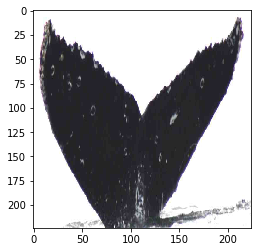

In [11]:
def ShowImg(img):
    plt.figure()
    plt.imshow(img.astype('uint8'))
    plt.show()
    plt.close()
batch = next(gen_tr)

img = batch[0]['anchor_input'][0]
print(img.shape)
mean = [103.939, 116.779, 123.68]
img[..., 0] += mean[0]
img[..., 1] += mean[1]
img[..., 2] += mean[2]
img = img[..., :: -1]
ShowImg(img)

### 5. Installation of Resnet 50 weight